## <center> Machine Learning from Scratch at ETH Zurich
## <center> 2. Regularization: Ridge Regression and LASSO with Cross Validation
## <center> 正则化：用交叉验证实现岭回归与LASSO
### <center> Zhaorui Gong &nbsp; 宫兆瑞

#### 注意：
1. 适用 regularization的情形：高维数据，甚至 p > n; 数据噪声很大；回归拟合而不是分类。
2. 适用LASSO的情形：希望选择features，比如当已知很多features无关；需要interpretability，即哪些因素重要；需要稀疏的模型。
3. 适用Ridge的情形：希望保全所有features，比如它们全都有物理/经济意义，只是shrink their coefficients；存在明显的多重共线性问题；希望光滑化的拟合结果。

### 2.1 Ridge Regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics   # 求 MSE用
from sklearn.datasets import make_regression  # 生成数据集用

In [148]:
class Ridge():
    def __init__(self, alpha = 0.1,
                lambda_grid = np.logspace(-4, 4, 100),  # define a grid of lambda values on a logarithmic scale, base 10
                fit_intercept = True,
                K = 5
                ):
        self.alpha = alpha  # since lambda is a keyword for Python, we use alpha instead, corresponding to the package.
        self.grid = lambda_grid
        self.fit_intercept = fit_intercept
        self.K = K
        self.coef = None
        

    def fit(self, X, y):         # analytic solution
        n, p = X.shape
        if self.fit_intercept:
            X = np.c_[np.ones(n), X]   # intercept is added to the matrix X
            p += 1
        I = np.identity(p)       # identity matrix of size p+1
        if self.fit_intercept:   # 注意：这两个 if 不能合并，因为 I的维度不定。
            I[0, 0] = 0              # the first element of the identity matrix is set to 0, 无需penalize intercept   
        self.coef = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y    # 解析解


    def CV_ridge(self, X, y):    # to find the optimal lambda, instead of the predefined one
        X = np.c_[np.ones(X.shape[0]), X]
        self.fit_intercept = False  # 接下来loop中调用fit，不能再加一列了
        kf = model_selection.KFold(n_splits = self.K, shuffle = True, random_state = 201)  # split the training data into K folds
        CV_record = []  # to store the CV error for each lambda
        for lam in self.grid:
            CV_error_folds = []
            for train_idx, eval_idx in kf.split(X):
                X_train_fold, X_eval_fold = X[train_idx], X[eval_idx]
                y_train_fold, y_eval_fold = y[train_idx], y[eval_idx]       # split and select the dataset using the corresponding index
                self.alpha = lam    # to update the lambda for fitting
                self.fit(X_train_fold, y_train_fold)         # nothing is returned, but the attribute is updated.
                y_hat_fold = X_eval_fold @ self.coef
                Rk_hat = np.mean((y_hat_fold - y_eval_fold)**2)   # the empirical loss
                CV_error_folds.append(Rk_hat)
            CV_error = np.mean(np.array(CV_error_folds))
            CV_record.append(CV_error)
        min_index = np.argmin(np.array(CV_record))     # model selection
        self.fit_intercept = True
        self.alpha = self.grid[min_index]
        print(f'The optimal lambda is: {self.alpha}')


    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.coef

Next, we create a dataset for ridge regression

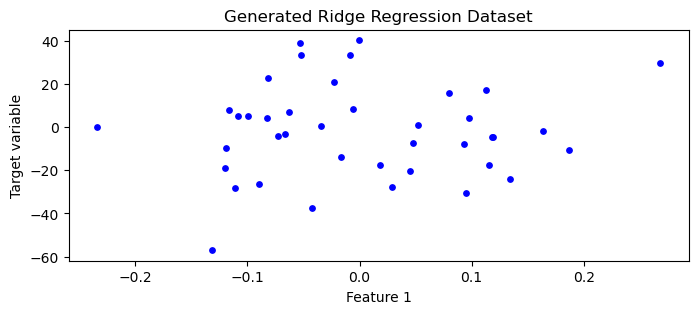

In [152]:
n_samples = 40
p_features = 60  # p很大，需要penalize. 这里甚至 n < p.
X, y = make_regression(n_samples=n_samples, n_features=p_features, noise=3, effective_rank=35, random_state = 201) # 噪声大，且 rank < p多重共线性
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.1, random_state = 200)
fig = plt.figure(figsize = (8,3))
plt.scatter(X[:, 0], y, color='blue', label='Data points', s = 15)
plt.xlabel('Feature 1')   # to be changed, since only 2-dim graph
plt.ylabel('Target variable')
plt.title('Generated Ridge Regression Dataset')
plt.show()

### 2.2 The evaluation of Ridge: Manual version vs packages

In [184]:
def mse(y_pred, y_test):
    return np.mean((y_pred - y_test)**2)

plm1 = Ridge(alpha = 0.1)   # 自定义lambda
plm1.fit(X_train, y_train)
y_pred1 = plm1.predict(X_test)
MSE1 = metrics.mean_squared_error(y_pred1, y_test)  # 测试：用我自己写的mse()一样
print(f'The MSE from scratch using predefined lambda is {MSE1}')

plm2 = Ridge()    # 用 CV找最优lambda
plm2.CV_ridge(X_train, y_train)
plm2.fit(X_train, y_train)
y_pred2 = plm2.predict(X_test)
MSE2 = mse(y_pred2, y_test)
print(f'The MSE after searching for the best lambda is {MSE2}')
print(f'The corresponding coefficients are \n {plm2.coef}.')

plm3 = linear_model.Ridge(alpha = 0.1)
plm3.fit(X_train, y_train)
y_pred3 = plm3.predict(X_test)
MSE3 = metrics.mean_squared_error(y_test, y_pred3)
print(f'The MSE using sklearn with predefined lambda is {MSE3}')   # 这包比我解析解居然还强

The MSE from scratch using predefined lambda is 345.1359755646004
The optimal lambda is: 0.0001
The MSE after searching for the best lambda is 333.2225973244329
The corresponding coefficients are 
 [ -2.5620732   15.66114495  24.83373396  17.25749359 -10.89601654
   0.52287285   3.68941992 -10.64890229  -4.2015144   -6.95140393
  -5.20046198 -12.02031273  50.80885116  -2.23941387   4.2587458
 -20.44476586   2.45801212  31.42649719   3.28160954   3.59057419
  -3.93437761  -7.43920407 -20.67595745   0.90795996   0.94498917
  15.22394736 -11.62470433   9.24565668 -12.05397227  21.80550944
 -12.86314744  -3.87102872  39.52233524  43.23639377  11.18175446
  48.72087072  13.27522569 -11.08481096  38.73244581  46.09317131
  -0.21319269 -12.30965661  -2.328968   -11.43671654 -20.28308156
  13.26684778  -2.40190146   1.69593711  10.29624442   5.88432195
   3.47833831  18.59836336  -4.11351455  30.50286221  14.59465458
  21.23193818  -3.15427082 -33.6803789    1.7857512    6.62283724
  39.376813

### 2.3 LASSO Regression
Least Absolute Shrinkage and Selection Operator

* Note that Lasso’s L1 penalty makes things a little tricky: the loss isn't differentiable when w = 0. So, we have to implement a soft-thresholding operator to handle the L1 term.
* Soft thresholding in GD: Unlike simple gradient descent, which oscillates near 𝑤=0, soft thresholding directly shrinks small weights to zero.

In [201]:
class LASSO():
    def __init__(self, 
                alpha = 0.002,
                lr = 0.001,
                max_iter = 100000,
                tol = 1e-6):
        self.alpha = alpha
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter
        self.coef = None

    def lasso_loss(self, X, y, w=None, lam=None):
        if w is None:  # Use self.coef if not provided
            w = self.coef
        if lam is None:  # Use self.alpha if not provided
            lam = self.alpha
        n, p = X.shape
        resid = y - X @ w
        squared_loss = np.sum(resid**2)  # Compute ||y - Xw||^2
        return squared_loss + lam * np.sum(np.abs(w))  # 加上 ||w||_1

    def lasso_GD(self, X, y):   # 这是个大致思路。实操中一定要掉包。手写的GD很不稳定。
        n, p = X.shape
        self.coef = np.zeros(p)
        for i in range(self.max_iter):
            w_t = self.coef
            y_hat = X @ w_t
            grad = -2/n * (X.T @ (y_hat - y))  # OLS grad
            self.coef -= self.lr * grad
            self.coef = np.sign(self.coef) * np.maximum(np.abs(self.coef) - self.alpha, 0)  # soft thresholding. 若lambda增大，则coef中会有更多项为0.
            if np.abs(self.lasso_loss(X, y) - self.lasso_loss(X, y, w = w_t)) <= self.tol:
                print(f'The change in loss is below the tolerance after the {i}th iterations')
                break

    def predict(self, X):
        return X @ self.coef
        

In [203]:
plm4 = LASSO()
plm4.lasso_GD(X_train, y_train)
y_pred4 = plm4.predict(X_test)
MSE4 = metrics.mean_squared_error(y_pred4, y_test)
print(plm4.coef)
print(f'The MSE using hand written LASSO is {MSE4}.')

plm5 = linear_model.Lasso(alpha = 0.1)
plm5.fit(X_train, y_train)
y_pred5 = plm5.predict(X_test)
MSE5 = metrics.mean_squared_error(y_pred5, y_test)
print(f'The MSE using sklearn package LASSO is {MSE5}.')
print("Nonzero coefficients:", np.sum(plm5.coef_ != 0))
print("LASSO Coefficients:", plm5.coef_)

[ -0.          -0.          -0.           0.          -0.
  -0.          -0.           0.           0.           0.
  -0.         -98.50927857  -0.           0.           0.
  -0.          -0.          -0.          -0.           0.
   0.           0.          -0.           0.          -0.
   0.           0.          -0.          -0.           0.
   0.          -0.          -0.          -0.          -3.25756323
  -0.           0.         -46.66731754  -3.14264342   0.
   0.           0.           0.           0.          -0.
  -0.           0.          -0.           0.          -0.
  -0.           0.          -0.          -0.          -0.
   0.           0.           0.          -0.          -0.        ]
The MSE using hand written LASSO is 544.1700392908203.
The MSE using sklearn package LASSO is 9.818297812621775.
Nonzero coefficients: 14
LASSO Coefficients: [-0.         10.82654364  0.         -0.         -0.          0.
 -0.          0.         -0.         -0.         -0.         86.

### 2.4 LASSO with Cross Validation

In [205]:
# Automatically find the best alpha using cross-validation
plm6 = linear_model.LassoCV(alphas=np.logspace(-4, 1, 100), cv=5)  # Try 100 values of lambda
plm6.fit(X_train, y_train)

# Best lambda
print("Optimal lambda:", plm6.alpha_)

# Fit final model with best lambda
lasso_best = linear_model.Lasso(alpha=plm6.alpha_)
lasso_best.fit(X_train, y_train)
y_best_pred = lasso_best.predict(X_test)
MSE6 = metrics.mean_squared_error(y_best_pred, y_test)
print(f'The MSE using LASSO CV package is {MSE6}.')

Optimal lambda: 0.029836472402833405
The MSE using LASSO CV package is 10.918080004160526.
